In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from sklearn.metrics import auc, roc_auc_score

/kaggle/input/tabular-playground-series-oct-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-oct-2021/train.csv
/kaggle/input/tabular-playground-series-oct-2021/test.csv


In [2]:
import datatable as dt
def data_load() -> pd.DataFrame:
    direсtory_kagggle = "/kaggle/input/tabular-playground-series-oct-2021/"
    train_data = "train.csv"
    test_data = "test.csv"
    sub_data = "sample_submission.csv"
    train = pd.read_csv(direсtory_kagggle + train_data)
    test = pd.read_csv(direсtory_kagggle + test_data)
    #train = dt.fread(direсtory_kagggle + train_data).to_pandas()
    #test = dt.fread(direсtory_kagggle + test_data).to_pandas()
    sub = pd.read_csv(direсtory_kagggle + sub_data)
    
    return train, test, sub

train, test, sub = data_load()

In [3]:
def reduce_memory_use(df: pd.DataFrame, verbose: bool=True) -> pd.DataFrame:
    num_col = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_memory_usage = df.memory_usage(deep=True).sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in num_col:
            col_min = df[col].min()
            col_max = df[col].max()
            if str(col_type)[:3] == "int":
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif str(col_type)[:5] == "float":
                if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif col_min > np.finfo(np.float64).min and col_max < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
    end_memory_usage = df.memory_usage(deep=True).sum() / 1024 ** 2
    if verbose:
        print(f"Суммарно памяти до: {start_memory_usage}", end="\n")
        print("Суммарно памяти после: ", end_memory_usage)
        
        return df
    
print("TRAIN", end="\n")
train = reduce_memory_use(train)
print("TEST", end="\n")
test = reduce_memory_use(test)

TRAIN
Суммарно памяти до: 2189.6363525390625
Суммарно памяти после:  505.447509765625
TEST
Суммарно памяти до: 1091.0035400390625
Суммарно памяти после:  252.24697875976562


<AxesSubplot:>

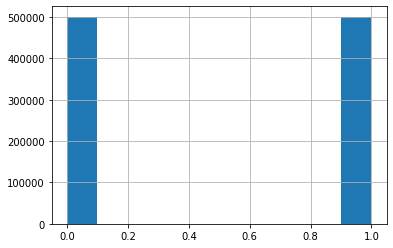

In [4]:
train['target'].value_counts()
train['target'].hist()

In [5]:
def prepare_data (train: pd.DataFrame, test: pd.DataFrame) -> list:
    train = train.drop(['id', 'target'], axis=1)
    test = test.drop(['id'], axis=1)
    features = train.columns
    train['target'] = 0
    test['target'] = 1
    train_test = pd.concat([train, test])
    target = train_test['target'].values
    
    return features, train_test, target

features, train_test, target = prepare_data(train, test)

In [9]:
import lightgbm as lgb
from sklearn.model_selection import KFold
param = dict(num_leaves = 40,
            min_data_in_leaf = 30,
            objective = 'binary',
            max_depth = 4,
            learning_rate = 0.006,
            min_child_samples = 20,
            boosting = 'gbdt',
            feature_fraction = 0.9,
            bagging_freq = 1,
            bagging_fraction = 0.9,
            bagging_seed = 27,
            metric = 'auc',
            verbosity = -1
            )
folds = KFold(n_splits=5, shuffle=True, random_state=1)
oof = np.zeros(len(train_test))

for fold_, (train_idx, val_idx) in enumerate(folds.split(train_test)):
    print(f'fold №{fold_}')
    train_data = lgb.Dataset(train_test.iloc[train_idx][features], label=target[train_idx])
    val_data = lgb.Dataset(train_test.iloc[val_idx][features], label=target[val_idx])
    #num_round = 30000
    clf = lgb.train(param,
                    train_data,
                    valid_sets=[val_data, train_data],
                    verbose_eval=1000,
                    early_stopping_rounds=1400)
    oof[val_idx] = clf.predict(train_test.iloc[val_idx][features])

fold №0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 1400 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.78351	valid_0's auc: 0.781913
fold №1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 1400 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.784152	valid_0's auc: 0.78259
fold №2
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
Training until validation scores don't improve for 1400 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.784773	valid_0's auc: 0.78419
fold №3
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_d

In [8]:
from sklearn.metrics import roc_auc_score
roc_auc_score(target, oof)

0.782485498326